In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.integrate import quad
from scipy.special import lambertw

def lv_rhs(t, z, a, b, c, d):
    x, y = z
    return [a*x - b*x*y, c*x*y - d*y]

def lv_short_rhs(t, z, beh_param=1):
    x, y = z
    return [beh_param*x*(1-y), y*(x-1)]

## LV trajectory examples and experiments.
<a id='experiments'></a>

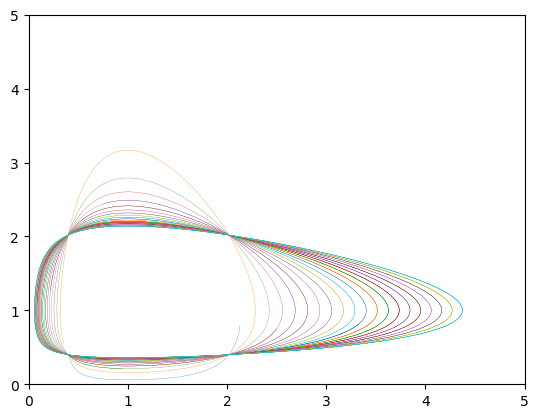

In [3]:
# local parameters for picture
start, end, pts = 0, 10, 1000
t = np.linspace(start, end, pts)
dt = t[1]-t[0]

# lv_param = (2/3, 4/3, 1, 1)
# sol = solve_ivp(lv_rhs, t_span=[start, end], y0=[0.5, 0.4],
#                 args=lv_param, method='Radau', dense_output=True)
# z = sol.sol(t)
# plt.plot(*z)
# plt.show()
    
# beh_param = (0.2,)
# sol = solve_ivp(lv_short_rhs, t_span=[start, end], y0=[0.5, 0.5],
#                 args=beh_param, method='Radau', dense_output=True)
# z = sol.sol(t)
# plt.plot(*z)
# plt.show()

for h in np.linspace(0.2, 5, 20):
    beh_param = (h,)
    # beh_param = (0.2 + np.power(h-0.2, 0.7),)
    sol = solve_ivp(lv_short_rhs, t_span=[start, end], y0=[0.4, 0.4],
                    args=beh_param, method='Radau', dense_output=True)
    z = sol.sol(t)
    plt.plot(*z,lw=0.2)
    # print(np.amin(z[0]),np.amin(z[1]))
plt.xlim(0,5)
plt.ylim(0,5)
plt.show()

## Data creation
For set of parameters $(a,b,c,d)$ using substitution: $u = \frac{c}{d}x\:$ and $v = \frac{b}{a}y\:$ we obtain normalized equations:
$$
\frac{du}{dt} = a\cdot u\:(1-v)\\
\frac{dv}{dt} = d\cdot v\:(u-1)
$$
Lets also change the time variable $\tau=\tau(t)=d\cdot t\:$, let $\tilde{u}(x) := u(\frac{1}{d}\cdot x)$ and 
$$
\frac{du}{dt}=\frac{d\:u(\frac{1}{d}\cdot(d\cdot t))}{dt}=\frac{\tilde{u}(\tau)}{d\tau}\frac{d\tau}{dt}=\frac{\tilde{u}(\tau)}{d\tau}\cdot d
$$
The above substitution changes the equation to:
$$
\frac{\tilde{u}(\tau)}{d\tau}\cdot d = a\cdot \tilde{u}\:(1-\tilde{v})\\
\frac{\tilde{v}(\tau)}{d\tau}\cdot d = d\cdot \tilde{v}\:(\tilde{u}-1)\\
\hphantom{a}\\
\text{which after dividing both eq. by }d\text{ yealds}\\
\hphantom{a}\\
\frac{\tilde{u}(\tau)}{d\tau} = \frac{a}{d}\cdot \tilde{u}\:(1-\tilde{v})\\
\frac{\tilde{v}(\tau)}{d\tau} = \tilde{v}\:(\tilde{u}-1)
$$
Therefore up to scaling in $x,y$ and $t$ solutions depend on one parameter call it "behaviour parameter" 
$$
beh\_param = \frac{a}{d},
$$
with one stable point equal $(1,1)$.

### Parameter space
Careful pick of parameters for the traning set is to avoid singular behaviour.\
For too small or too large $beh\_param$ and/or too small starting position $y0$\
there are problems:
1. The atto-fox problem
2. Solution moves very slowly

Here we decide ranges of $beh\_param$, $(a,b,c,d)$, and time domain.
From [experiments](#experiments) we shall take
$$
beh\_param\in [0.2,5]
$$
Parameter $a$ marks the growth of population of pray, lets allow 
$$
a\in [0.2,2]
$$

#### Parameter $d$
We can find parameter $d$ for every pair $a$ and $beh\_param$, from relation  
$$
beh\_param = \frac{a}{d}
$$
Therfore pairs $(a,d)$ are on the intersections:

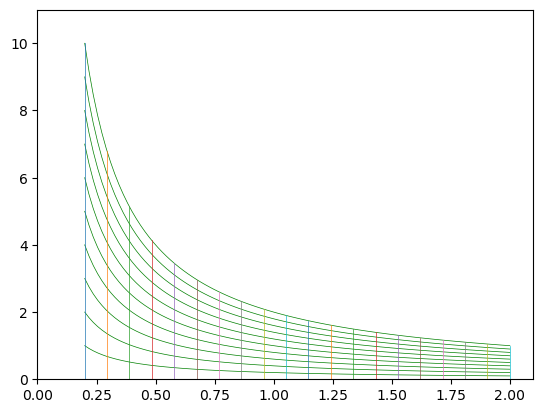

In [4]:
for beh_param in np.linspace(0.2, 2, 10):
    a = np.linspace(0.2,2,100)
    y = beh_param/a
    plt.plot(*np.array([a,y]),lw=0.5,c='g')
    
for x_vert in np.linspace(0.2,2,20):
    a = np.array([x_vert]*2)
    y = np.array([0,2/x_vert])
    plt.plot(*np.array([a,y]),lw=0.5)
plt.xlim(0,2.1)
plt.ylim(0,11)
plt.show()

#### Parameters $c$ and $b$
Are responsible for linear scaling. For fixed pair $(a,b)$\
equilibrium point is going to be $(x,y) = (\frac{c}{d}),\frac{b}{a}$.

#### Test variable change - time domain and starting position (There and back again).
Solve classical equation with $(a,b,c,d)$ on interval $(0,8)$ and $y0=(0.5,0.5)$ , and normalised one.\
Check if a normalised solution after inverted transformations is equal to the original one.\
Lets work with parameters tuple $test\_param = (2/3, 4/3, 1, 0.9)$\
Linear trans:
$$
u = \frac{c}{d}x \quad\text{ and }\quad v = \frac{b}{a}y
$$
Starting position $(x_0,y_0) = (0.5,0.5)$ transforms into 
$$
u_0 = \frac{1}{0.9}\cdot 0.5 = 0.5(5)  \quad\text{ and }\quad v_0 = \frac{4/3}{2/3}\cdot 0.5 = 1
$$
Time domain transformations are 
$$
\tau=\tau(t)=d\cdot t \quad\text{and}\quad t = t(\tau) = \frac{\tau}{d}$$
Therefore solution of LV$(a,b,c,d)$, $(x,y)(t)$ on the interval $t\in[0, T]$, after normalisation $(u,v)(\tau)$ the time $\tau$ will belong to $\tau\in[0, d\cdot T]$.

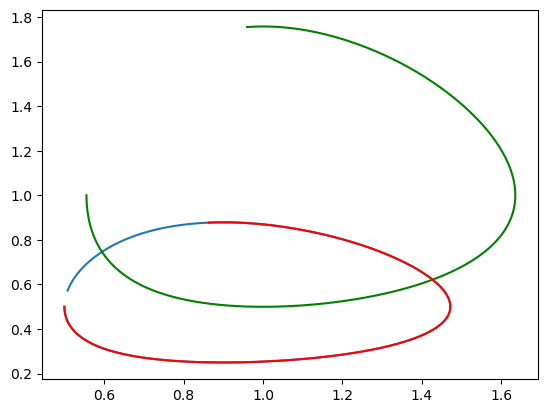

In [5]:
# time domain for normalised eq. is [0,8]/0.9 = [0, 8/0.9] (Look below in Time section to see that T = 8.3408228)

test_sol = solve_ivp(lv_rhs, t_span=[0, 8], y0=[0.5, 0.5],
                args=(2/3, 4/3, 1, 0.9), method='Radau', dense_output=True)
test_z = test_sol.sol(np.linspace(0, 8, 500))

# for the normalised solution beh_param = a/d = (2/3)/0.9 = (2/3)/0.9 starting position has changed
# original y0 = [0.5, 0.5], under linear 

nor_test_sol = solve_ivp(lv_short_rhs, t_span=[0, 8*0.9], y0=[(1/0.9)*0.5,1],
                args=((2/3)/0.9,), method='Radau', dense_output=True)
nor_test_z = nor_test_sol.sol(np.linspace(0, 8*0.9, 500)*0.8)
ekhem_z = np.array([[0.9,0],[0,0.5]])@nor_test_z


plt.plot(*test_z)
plt.plot(*nor_test_z,c='g')
plt.plot(*ekhem_z,c='r')
plt.show()

# Napisz odpowiednie transformaty: ((a,b,c,d,t=1),[[x0,x1,...],[y0,y1,...]]) <-> (beh_param, t=?,[[u0,u1,...],[v0,v1,...]])

#### The traning, input and output
Trajectories in traning set are of the length $m+1$
The network will take $n+1$ points ($n+1$ smaller(<<) than $m$)
$$
[z(t), z(t+\Delta t),z(t+2\Delta t),\cdots, z(t+n\cdot \Delta t)]\quad \text{and try to predict next k points}\quad
[z(t+(n+1)\cdot\Delta t), z(t+(n+2)\cdot\Delta t),\cdots,z(t+(n+k)\cdot\Delta t)]
$$
During the traning we would like to take one trajectory $z=[z_0,z_1,\ldots,z_m]$ and perform:\
\
$[z_0,z_1,\cdots,z_n]\quad \text{compare network output against}\quad [z_{n+1},z_{n+2},\cdots,z_{n+k}]$,\
$[z_1,z_2,\cdots,z_{n+1}]\quad \text{compare network output against}\quad [z_{n+2},z_{n+3},\cdots,z_{n+k+1}]$,\
$\vdots$\
$[z_{m-(k+2)},z_{m-(k+n+1)},\cdots,z_{m-(k+3)}]\quad \text{compare network output against}\quad [z_{m-(k+2)},z_{m-(k+1)},z_{m-k},\cdots,z_{m-1}]$,\
$[z_{m-(k+n+1)},z_{m-(k+n)},\cdots,z_{m-(k+2)}]\quad \text{compare network output against}\quad [z_{m-(k+1)},z_{m-k},z_{m-(k-1)},\cdots,z_{m}]$\
As if input is sliding on the trajectory.\
\
With perfect solutions we could take indecies modulo $m$ but it might be easier for a traning set to overlap on $m+k$ points.

#### TIME
We would like to produce a dataset for which the time frequency will be the same for all parameters (a,b,c,d)./
Moreover it would be nice for each trajectory to have at least one full period.
1. Variable $T=T(a/d, x0, y0)$ in $[0,T]$
2. Do not care and take $T$ such that the solwest moving trajectory goes round once.\
    potential drawback: faster moving trajectories closer to the middle of parameter set\
    will be more numerous and create a bias ?


Theorem 6.2 in "The period of Lotka-Volterra system" helps calculate the period.

In [6]:
# again take : y0=[0.5, 0.5], args=(2/3, 4/3, 1, 0.9)

def lv_energy(x, y, a, b, c, d):
    """ (x(t), y(t)) - (pray, predator)
        lv_energy(x,y) = 0 for x = d/c, y=a/b
    """
    return c*x-d+b*y-a-a*np.log(y*b/a)-d*np.log(x*c/d)
# lv_energy(0.5,0.5,2/3, 4/3, 1, 0.9)

def lv_phi(s):
    """ where phi(s) is ... """
    a = np.reciprocal(1+lambertw(-np.exp(-1-s), k=0))
    b = np.reciprocal(1+lambertw(-np.exp(-1-s), k=-1))
    return np.real(a-b)

def lv_period(energy, a, d):
    """ Theorem 6.2 from https://www.jstor.org/stable/43834050 
        period of lotka-volterra depends on energy and params a,d """
    y, err = quad(lambda s: np.reciprocal(a*d) * lv_phi(s/d) * lv_phi( (energy-s)/a ),
                  0, energy, full_output=0)
    return y

# #check:
# #a,b,c,d = 2/3, 4/3, 1, 0.9
# #x,y = 0.5,0.5
# energy = lv_energy(0.1,0.1,2/3, 4/3, 1, 0.9)
# lv_period(energy,2/3,0.9)

def lv_priod_y0_param(x, y, a, b, c, d):
    energy = lv_energy(x,y, a, b, c, d)
    return lv_period(energy, a, d)
lv_per_vect = np.vectorize(lv_priod_y0_param)

23.844131129795155
13.688984045538321
10.5769634595867
8.938139849495588
7.889792007043835
7.146667412746644
6.585187885495331
6.142042178010332
5.7810183282851995
5.479716342902559


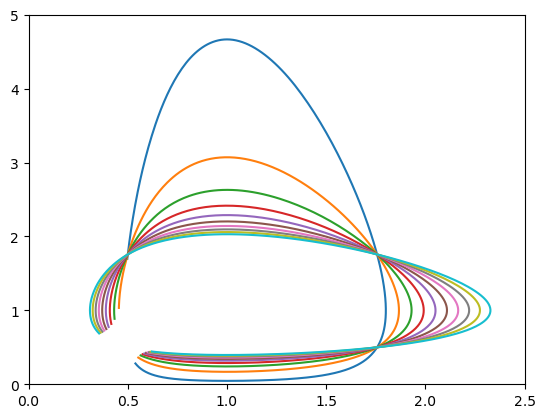

In [7]:
for a in np.linspace(0.1,1.5,10):
    #a,b,c,d = a, 4/3, 1, 0.6/a
    #x,y = 0.5,0.5
    energy = lv_energy(0.5,0.5,a, a, 1, 1)
    perio = lv_period(energy,a,1)
    print(perio)
    sol = solve_ivp(lv_rhs, t_span=[0, perio], y0=[0.5, 0.5],
                args=(a, a, 1, 1), method='Radau', dense_output=True)
    t = np.linspace(perio*0.05, perio*0.9, 500)
    z = sol.sol(t)
    plt.plot(*z)
# plt.plot(np.array([[1,1]2),'o')
plt.xlim(0,2.5)
plt.ylim(0,5)
plt.show()

### Possible starting points and beh_params
The strategy for creation data set will be:
   1. Start with a table of every acceptable pair: (beh_par, starting_point), for every such pair 
       we can already calculate the period lets store it as the third thing in matrix init_nor_lv_params.
       Therefore it will be array of shape (3, x_N, beh_N) <- 3 matriecies x_N x beh_N, the first matrix stores behavior, 
       second: starting point, the last one will keep the period.
   2. For every such pair create a set of solutions with scaling (depending on a,b,c,d) in x,y, 
       and t which will be another table, append those to set of solutions.
   3. While at this, save parallelly tables of parameters used to create the solutions.

In [8]:
# 1 initial table for normalised solutions.

beh_min, beh_max, beh_N =  0.2, 5, 7
x_min, x_max, x_N = 0.1, 0.9, 5

x_zeros = np.linspace(x_min, x_max, x_N)
beh_parameters = np.linspace(beh_min, beh_max, beh_N)

init_params_for_nor_lv = np.zeros((3, x_N, beh_N))
init_params_for_nor_lv[:2] = np.meshgrid(beh_parameters, x_zeros)
init_params_for_nor_lv[2] = np.apply_along_axis(
                                lambda x: lv_priod_y0_param(x[1], x[1], x[0], x[0], 1, 1),
                                axis=0, arr=init_params_for_nor_lv[:2])
np.around(init_params_for_nor_lv,2) # preview

array([[[ 0.2 ,  1.  ,  1.8 ,  2.6 ,  3.4 ,  4.2 ,  5.  ],
        [ 0.2 ,  1.  ,  1.8 ,  2.6 ,  3.4 ,  4.2 ,  5.  ],
        [ 0.2 ,  1.  ,  1.8 ,  2.6 ,  3.4 ,  4.2 ,  5.  ],
        [ 0.2 ,  1.  ,  1.8 ,  2.6 ,  3.4 ,  4.2 ,  5.  ],
        [ 0.2 ,  1.  ,  1.8 ,  2.6 ,  3.4 ,  4.2 ,  5.  ]],

       [[ 0.1 ,  0.1 ,  0.1 ,  0.1 ,  0.1 ,  0.1 ,  0.1 ],
        [ 0.3 ,  0.3 ,  0.3 ,  0.3 ,  0.3 ,  0.3 ,  0.3 ],
        [ 0.5 ,  0.5 ,  0.5 ,  0.5 ,  0.5 ,  0.5 ,  0.5 ],
        [ 0.7 ,  0.7 ,  0.7 ,  0.7 ,  0.7 ,  0.7 ,  0.7 ],
        [ 0.9 ,  0.9 ,  0.9 ,  0.9 ,  0.9 ,  0.9 ,  0.9 ]],

       [[25.94,  9.45,  7.24,  6.3 ,  5.77,  5.43,  5.19],
        [18.46,  7.38,  5.57,  4.74,  4.25,  3.93,  3.69],
        [15.72,  6.69,  5.02,  4.21,  3.73,  3.39,  3.14],
        [14.53,  6.4 ,  4.78,  3.99,  3.5 ,  3.16,  2.91],
        [14.09,  6.29,  4.69,  3.91,  3.42,  3.07,  2.82]]])

### now for every entry beh, x0, duration we scale them with a, b, c, d going back to x,y variables

#### first lets check how from normalised solution create solutions for eq with a,b,c,d
_rec is from "to recovering" _nor is from "normalised"\
parameters b,c we can choose more or less freely but d and a are bound by equality beh = a/d

In [9]:
def var_change_X_to_U(arr, param: tuple ):
    """ Applies (u = u(x) = c/d x, v = v(y) = d/c y) change of variables on array of points arr.
        Stationary point of LV(a,b,c,d) system is transformed under this change to (1,1).
        Parameters  arr  :  np.array of shape (2,N) 
                            (shape of scipy_ivp(...,dense_output=True).sol(arr of times) )
                    param: tuple of length 4 - parameters of Lotka-Volterra ODE"""
    a, b, c, d = param
    change_matrix = np.array([[c/d, 0],[0, b/a]])
    return change_matrix @ arr

def var_change_U_to_X(arr, param: tuple ):
    """ Applies (x = x(u) = d/c u, y = y(v) = c/d v) change of variables on array of points arr
        Stationary point (1,1) of normalised system LV(beh,beh,1,1) is transformed under this change to (,1)
        Parameters  arr  :  np.array of shape (2,N) 
                            (shape of scipy_ivp(...,dense_output=True).sol(arr of times) )
                    param: tuple of length 4 - parameters of Lotka-Volterra ODE"""
    a, b, c, d = param
    change_matrix = np.array([[d/c, 0],[0, a/b]])
    return change_matrix @ arr

Want to find a solution to LV(0.85, 1.12, 1.1, 0.9) (starting point will be given by normalised)\
beh parameter is a/d = 0.85/0.9\
let (x0, x0) be (0.6, 0.6)\
parameters for normalised system are:

In [10]:
x0 = 0.6
beh = 0.85/0.9
dur = lv_priod_y0_param(0.6, 0.6, beh, beh, 1, 1)

Now, lets go back to solution of LV(0.85, 1.12, 1.1, 0.9) (starting at var_change_U_to_X([x0, x0])\
and compare it to a normalised with changed variables applied.

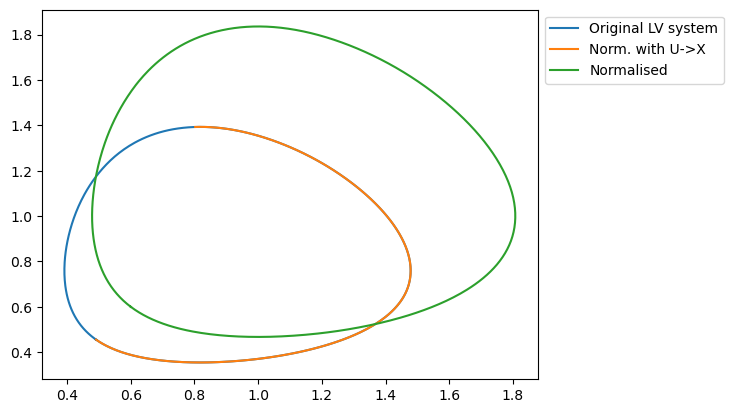

In [11]:
point = var_change_U_to_X(np.array([[0.6],[0.6]]), param = (0.85, 1.12, 1.1, 0.9))
# point.T[0]

fig, ax = plt.subplots()

#solving the original one (durtion is scaled in normalised variables)
sol = solve_ivp(lv_rhs, t_span=[0, dur/0.9], y0=point.T[0],
                args=(0.85, 1.12, 1.1, 0.9), method='Radau', dense_output=True)
t = np.linspace(0, (dur/0.9), 500)
z = sol.sol(t)
ax.plot(*z, label="Original LV system")

# solving normalised and changing variables
sol = solve_ivp(lv_rhs, t_span=[0, dur], y0=[x0, x0],
                args=(beh, beh, 1, 1), method='Radau', dense_output=True)
t = np.linspace(0, (dur)*0.6, 500)
z = sol.sol(t)
z = var_change_U_to_X(z, (0.85, 1.12, 1.1, 0.9) )
ax.plot(*z, label="Norm. with U->X")

# normalised 
sol = solve_ivp(lv_rhs, t_span=[0, dur], y0=[x0, x0],
                args=(beh, beh, 1, 1), method='Radau', dense_output=True)
t = np.linspace(0, dur, 500)
z = sol.sol(t)
ax.plot(*z, label="Normalised")


ax.legend(loc='upper left',bbox_to_anchor=(1,1))
plt.show()

Going the other way:\
One solution of normalised system LV(beh, beh, 1, 1) at [x0, x0]\
gives solution to many LV systems.\
The restrictions are that beh = a/d. Lets see some examples:

assume that beh = 2/3
for a fixed pair (b,c) form (a, 1.12, 1.1, a/beh)

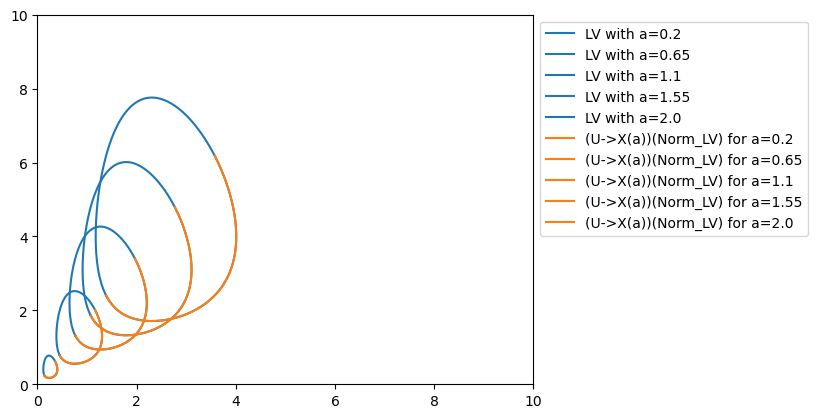

In [99]:
beh = 2/3
x0 = 0.6
dur = lv_priod_y0_param(x0, x0, beh, beh, 1, 1)
b, c = 0.5, 1.3

num_of_curves = 5

fig, ax = plt.subplots()

# original equations:
for i,a in enumerate(np.linspace(0.2, 2, num_of_curves)):
    d = a/beh
    point = var_change_U_to_X(np.array([[0.6],[0.6]]), param = (a, b, c, d))
    sol = solve_ivp(lv_rhs, t_span=[0, dur/d], y0=point.T[0],
                    args=(a, b, c, d), method='Radau', dense_output=True)
    t = np.linspace(0, (dur/d), 500)
    z = sol.sol(t)
    ax.plot(*z, c='tab:blue',label=f"LV with a={np.around(a,2)}")

# solving normalised and applying U_to_X transformation

sol = solve_ivp(lv_rhs, t_span=[0, dur], y0=[x0, x0],
                args=(beh, beh, 1, 1), method='Radau', dense_output=True)
t = np.linspace(0, dur*0.52, 500)
z = sol.sol(t)
for i,a in enumerate(np.linspace(0.2, 2, num_of_curves)):
    d = a/beh
    z_trans = var_change_U_to_X(z, (a, b, c, d) )
    ax.plot(*z_trans, c='tab:orange',label=f"(U->X(a))(Norm_LV) for a={np.around(a,2)}")

ax.legend(loc='upper left',bbox_to_anchor=(1,1))
plt.xlim(0,10)
plt.ylim(0,10)
plt.show()

In [102]:
np.amin(z[1])

0.4276977436019371

Function ```var_change_X_to_U``` and ```var_change_U_to_X``` seem to\
correctly transform solutions.\
This enables us to solve relatively few ODE's (beh, beh, 1, 1) and to solutions apply transformations var_change_U_to_X.

Tables of normalised parameters and data creation.

In [95]:
from dataclasses import dataclass

@dataclass
class Data_Setup:
    """ General constants in data creation"""
    pts: int = 500

@dataclass
class Normalised_Parameter_Bounds:
    """ data class holding 
        'min', 'max' and 'number of' of behaviour parameter (beh) and starting point [x, x] """
    # bounds for behaviour parameter = a/d
    beh_min: float = 0.2    
    beh_max: float = 5
    beh_N:   int = 15
    # bounds for starting point [x,x]
    x_min:   float = 0.2
    x_max:   float = 0.95
    x_N:     int = 20
    # numebr of points in trajectory
    traj_N:  int = 500

def init_parameter_table(bounds: Normalised_Parameter_Bounds):
    ''' Function creating an initial parameter table from bounds.
        Returns an array of shape (3,N,M) 
            first - (N,M) array contain behaviour parameters
            secon - (N,M) array contain x0 starting points
            third - (N,M) array contain the period of LV(beh,beh,1,1) at [x,x],
                    where beh,x have same last two indecies.
        Parameters:
        bounds: Normalised_Parameter_Bounds'''
    
    x_s        = np.linspace(bounds.x_min,   bounds.x_max,   bounds.x_N)
    beh_params = np.linspace(bounds.beh_min, bounds.beh_max, bounds.beh_N)
    
    res     = np.zeros((3, bounds.x_N, bounds.beh_N))
    res[:2] = np.meshgrid(beh_params, x_s)
    res[ 2] = np.apply_along_axis(
                lambda x: lv_priod_y0_param(x[1], x[1], x[0], x[0], 1, 1),
                axis=0, 
                arr=res[:2] )
    return res

bounds = Normalised_Parameter_Bounds()
init_params = init_parameter_table(bounds)

For every tuple - ```(beh, x, dur)``` 1 dimentional slice of the form ```init_parameter_table[:,i,j]``` we want to create\
normalized solution LV(beh, beh,1,1) at (x,x) and apply to transformation U->X with parameters a,b,c.

In [103]:
def normalized_data_generator(func, bounds: Normalised_Parameter_Bounds,
                              path: str, name: str):
    """ Function that generates normalised LV solutions and stores it under path,
        along with table of parameters for generated trajectories.
        Saved tables are of shapes:
            data   = (bounds.x_N * bounds.beh_N, 2, traj_N)
            params = (bounds.x_N * bounds.beh_N, 3)
        The parameters of solution saved ith row of data is saved 
        in ith row of params.
            func is RHS of ODE and takes 4 parameters from arg in solve_ivp
        """
    init_params = init_parameter_table(bounds)
    
    arr                     = np.zeros([bounds.x_N, bounds.beh_N])
    normalized_trajectories = np.zeros((bounds.x_N*bounds.beh_N, 2, bounds.traj_N))
    normalized_parameters   = np.zeros((bounds.x_N*bounds.beh_N, 5))
    
    for idx, value in np.ndenumerate(arr):
        # solving LV with parameters:
        beh, x0, dur = init_params[:, idx[0], idx[1]]
        sol = solve_ivp(func, t_span=[0, dur], y0=[x0, x0],
                    args=(beh, beh, 1, 1), method='Radau', dense_output=True)
        t = np.linspace(0, dur, bounds.traj_N)
        z = sol.sol(t)
        z_xmin, z_ymin = np.amin(z[0]), np.amin(z[1])
        # saving trajectories z in the array:
        index = idx[0] * bounds.beh_N + idx[1]
        normalized_trajectories[index] = z
        normalized_parameters[index]   = np.array([beh, x0, dur, z_xmin, z_ymin])
        
    np.save(file=path+'/'+name+'_trajectories.npy',arr=normalized_trajectories)
    np.save(file=path+'/'+name+'_parameters.npy',arr=normalized_parameters)

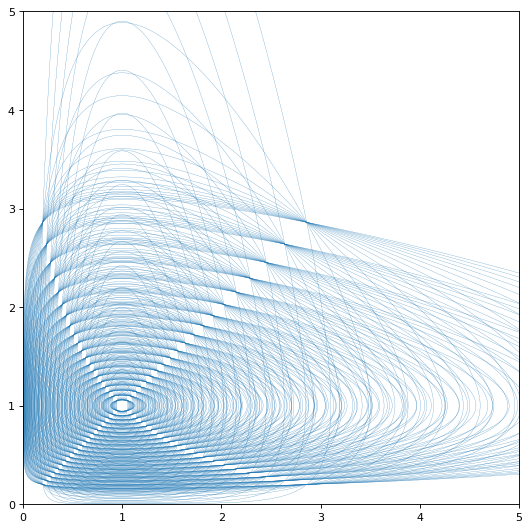

In [104]:
normalized_data_generator(func=lv_rhs, bounds=bounds, path='data', name='normalized')


zl = np.load('data/normalized_trajectories.npy')

fig, ax = plt.subplots(figsize=(8, 8), dpi=80)

for traj in zl:
    ax.plot(*traj, c='tab:blue',lw=0.2)
    # print(traj.shape)
    

plt.xlim(0,5)
plt.ylim(0,5)
plt.show()

### Scaling the solutions 
For every normalised trajectory we "move it" with scaling (1,1) -> (d/c, a/b) with var_change_U_to_X(a,b,c,d)\
The constrain beh = a/d (*) play a role here as we can only choose a,d such that (*) is true.\
We also want to be careful not to scale solutions that are aready close to zero further luckily we have\
parameters xmin, ymin in parameter file and we can scale every solution relatively to avoid going below some threshold point (eg. (1E-4,1E-4-)).\
for the ```i```-th solution\
To do this relative scaling we shall use\
the point (z_xmin,z_ymin) := ```normalized_parameters.npy[i][-2:]``` = (the smallest ```x``` on ```i```th sol, the smallest ```y``` on ```i```th sol)
1. Find scaling which sends (z_xmin, z_ymin) to (x_tresh, y_tresh)
2. Use scalings which are bigger than those. 

This approch has a benefit that even if our normalised solutions went beyoned treshold point,\
on the second step we will rescue those solutions. Drawback: they might get nummerically unstable ?

Maximal scaling should be 
1. Bigger than minimal scaling :D
2. smaller than a set parameter or smaller than some relative range

For normalised solution stationary point is always (1,1), lets relate the maximal scaling with the minimal following the rule:\
If scale_min is smaller than 1 then we have maximal fixed point condition,\
If scale_min is greater than one then we multiply maximal_scailing minimal scaling.\
This is ```max_scale``` function below.

Note:\
Minimal scaling is minimal fixed point :D, since the point (1, 1) under scaling is sent to (scale_X, scale_Y)

solution is geq than:[0.21223697 0.46391323]
min scale = [0.47117145 0.21555755]
pars = [0.2  0.93 0.64 0.3 ], fixed pt. =[0.47 0.22]
pars = [0.8  3.71 2.55 1.2 ], fixed pt. =[0.47 0.22]
pars = [1.4  6.49 4.46 2.1 ], fixed pt. =[0.47 0.22]
pars = [2.   9.28 6.37 3.  ], fixed pt. =[0.47 0.22]


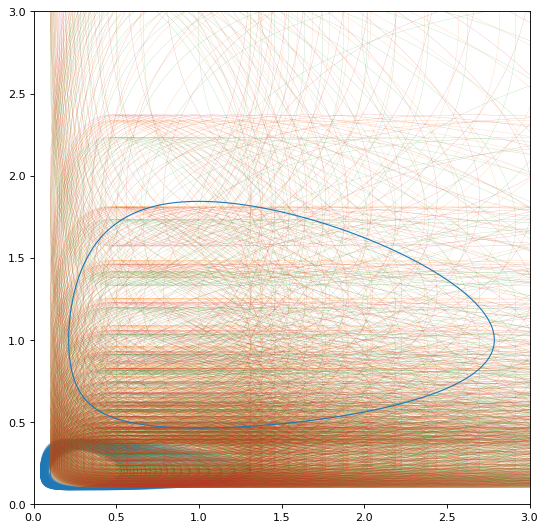

In [165]:
zl   = np.load('data/normalized_trajectories.npy')
zpar = np.load('data/normalized_parameters.npy')
zl_part = zl[129:130]
z_min = np.array(zpar[129][-2:])
print(f'solution is geq than:{z_min}')
tresh = 0.1

# find critical scaling:
scale_min = np.linalg.solve(np.diag(z_min), np.array([tresh,tresh]))
print(f'min scale = {scale_min}')

def max_scale(scale_min, scale_max=2):
    return numpy.piecewise(scale_min,[scale_min <=1,scale_min>1], lambda x: scale_max, lambda x: scale_min*scale_max )
fig, ax = plt.subplots(figsize=(8, 8), dpi=80)
# for every (a,b) critical scaling gives us upper bounds for c , b:
colors = ['tab:blue','tab:orange','tab:green', 'tab:red']
for i,a in enumerate(np.linspace(0.2, 2, 4)):
    d = a/beh
    c = d/tresh*z_min[0]    # x cord. scaling
    b = a/tresh*z_min[1]    # y cord. scaling
    print(f'pars = {np.around((a,b,c,d),2)}, fixed pt. ={np.around((d/c,a/b),2)}')
    
    b_s  = np.linspace(np.amin([b, 1/b]),np.amax([b, 1/b]),20)
    c_s  = np.linspace(np.amin([c, 1/c]),np.amax([c, 1/c]),20)
    bc_s = np.array(np.meshgrid(b_s, c_s))
    for idx, el in np.ndenumerate(bc_s[0]):
        # print(idx,el, (1, idx[0], idx[1]))
        ax.plot(*var_change_U_to_X(traj, (a, el, bc_s[1, idx[0], idx[1]], d)), c=colors[i],lw=0.1)

# for every (a,b) fixed_number

for traj in zl_part:
    ax.plot(*traj, c='tab:blue',lw=1)
    # print(traj.shape)
# plt.axvline(x = 0.21223697)
# plt.axhline(y = 0.46391323)

plt.xlim(0,3)
plt.ylim(0,3)
plt.show()

In [152]:
# at = np.linspace(0,1,5)
# bt = np.linspace(2,3,4)
ct = np.meshgrid(at, bt)
# for idx, el in np.ndenumerate(ct[0]):
#     print(idx, el)


list

In [16]:
#custom dataloader
def npy_loader(path):
    sample = torch.from_numpy(np.load(path))
    return sample
    

dataset = datasets.DatasetFolder(
    root='PATH',
    loader=npy_loader,
    extensions=['.npy']
)

NameError: name 'datasets' is not defined